# Traffic Prediction 

In [15]:
## import package

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")


In [16]:
## loading data

df = pd.read_csv("E:\\GreekforGreeksProject\\kaggle/traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


Here, Datetime data is in object. we need to process it

In [18]:
## process time data

df['DateTime'] = pd.to_datetime(df['DateTime'])

In [19]:
## drop ID

df = df.drop('ID', axis=1)

In [20]:
df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


Now, the dataset is clean...

In [21]:


df_ = df.copy()
df_.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


Text(0.5, 0, 'Date')

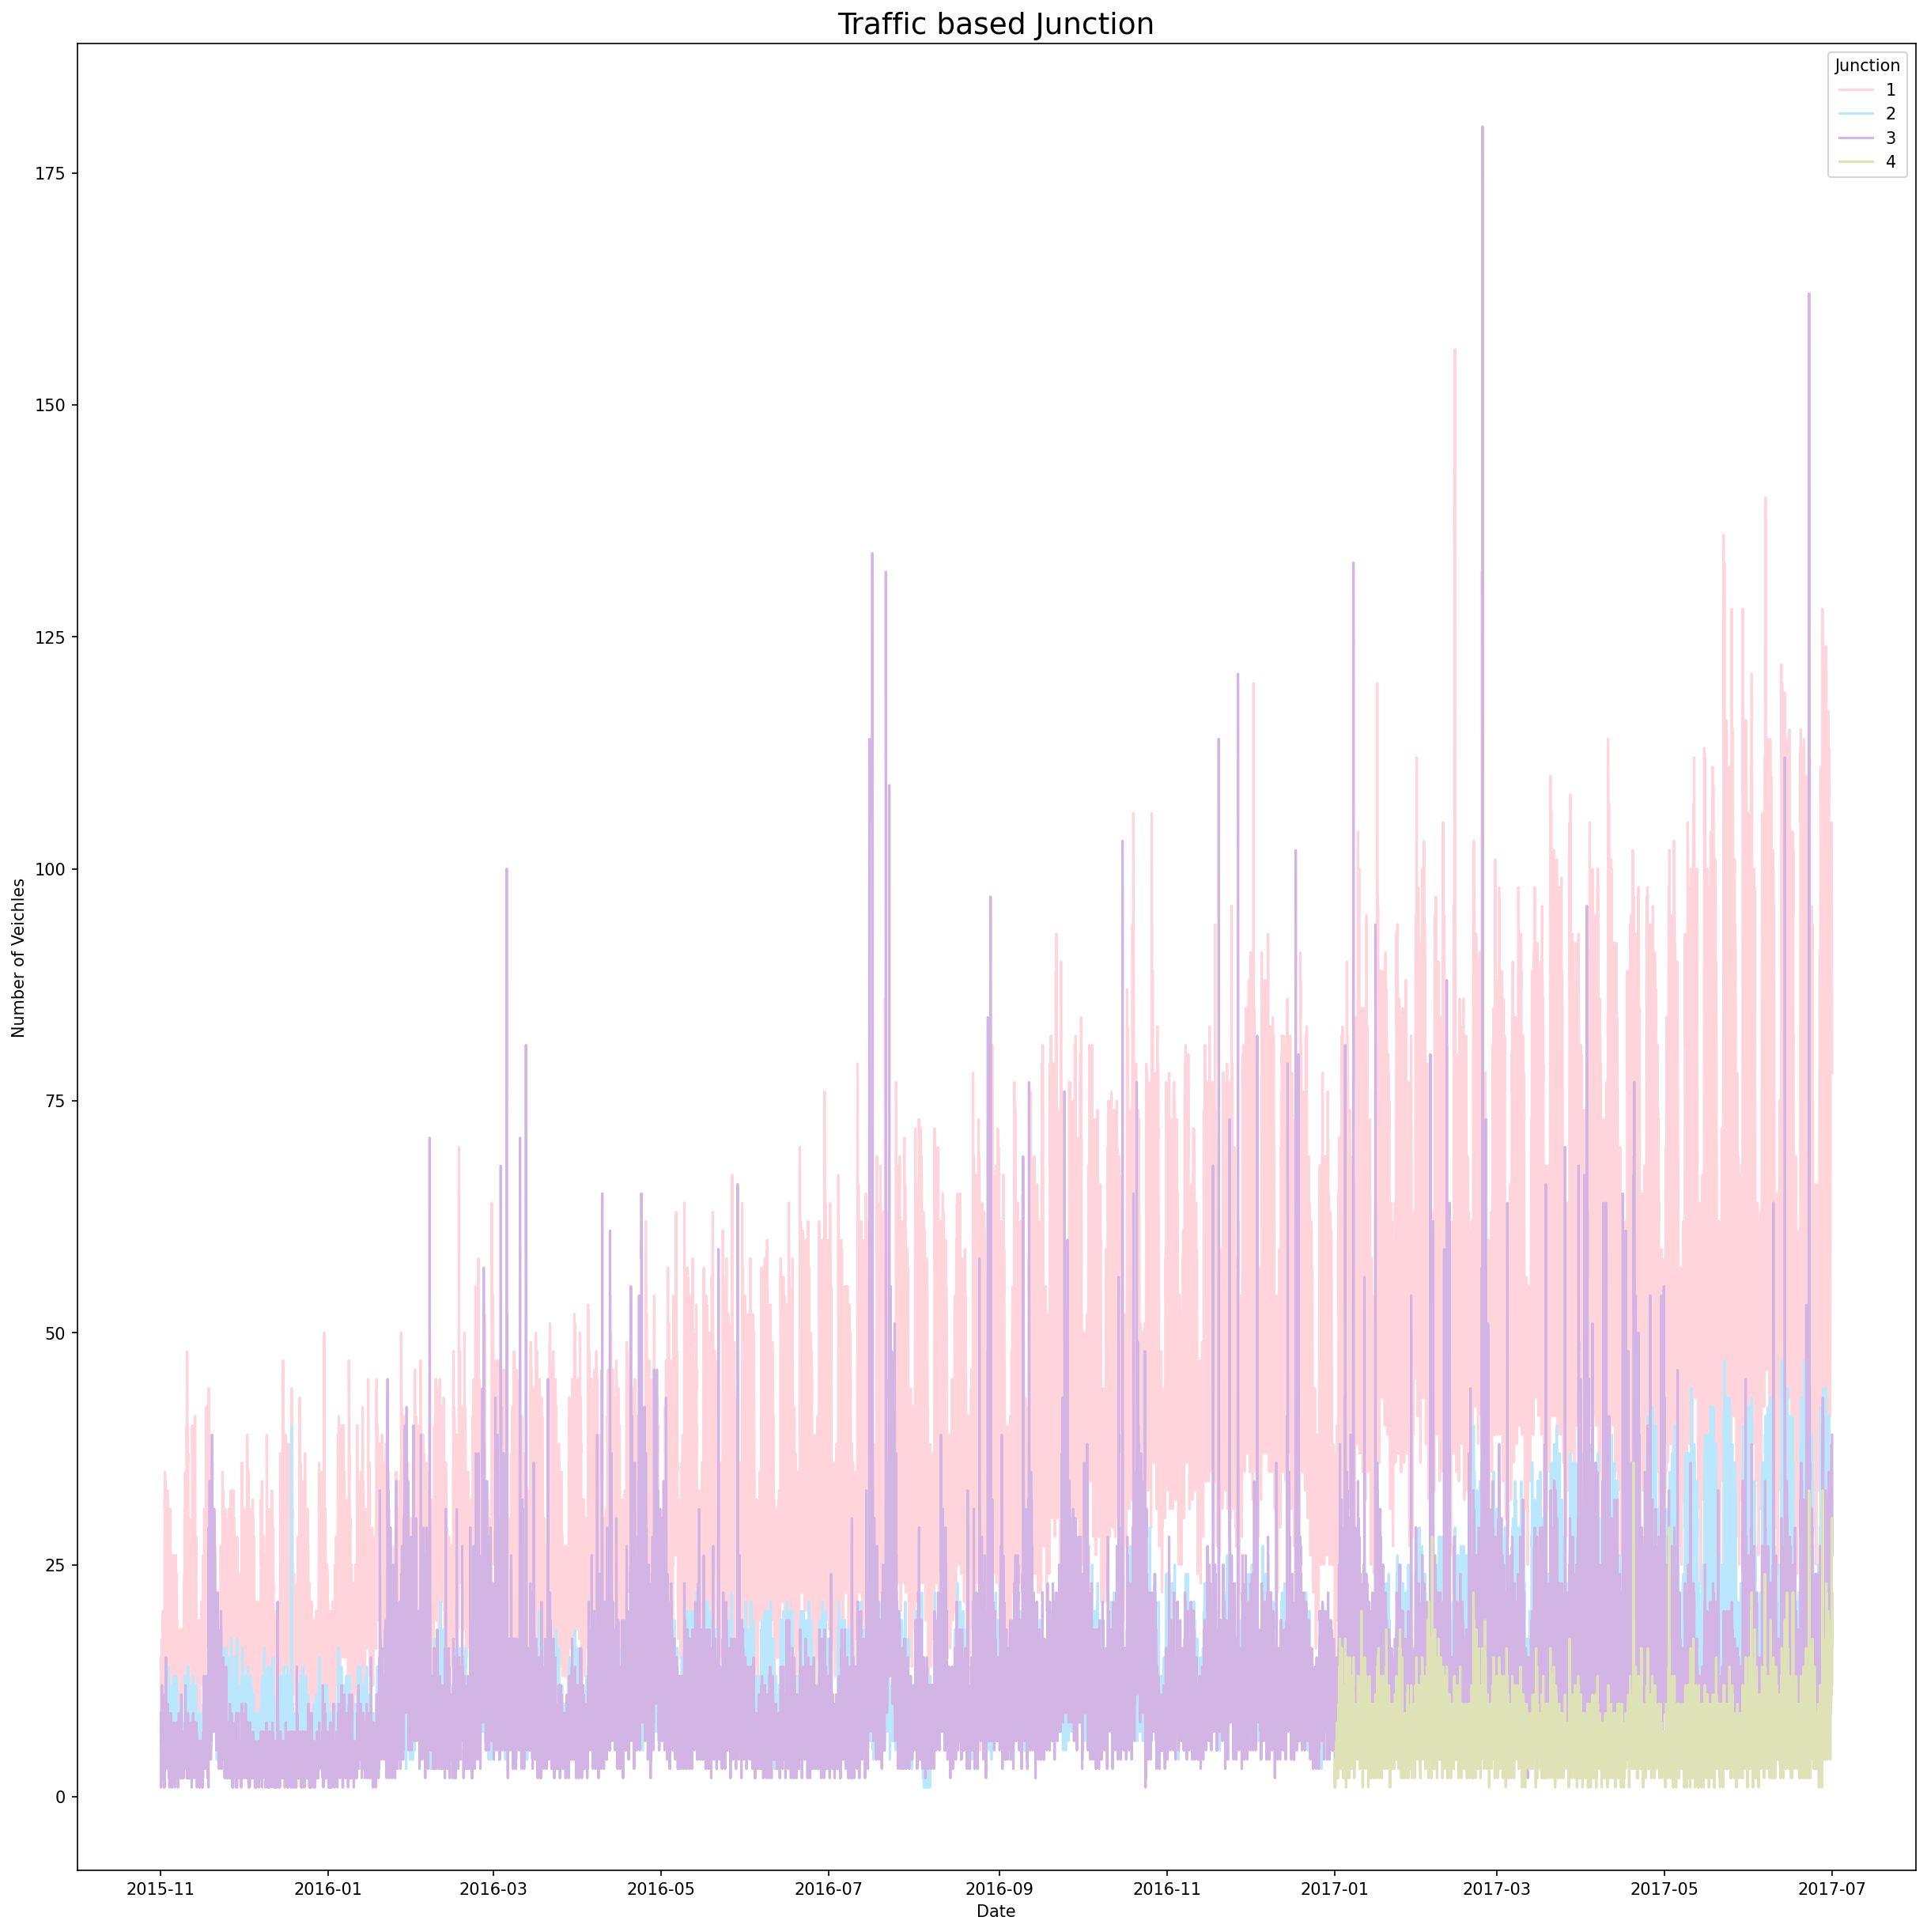

In [9]:
## lets speak with data


palette = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20, 20), dpi=150)
series = sns.lineplot(x=df_['DateTime'], y = "Vehicles", data=df_, hue="Junction", palette=palette)
series.set_title("Traffic based Junction", fontsize=18)
series.set_ylabel("Number of Veichles")
series.set_xlabel('Date')

In [22]:
## waite Waite, let data talk more

df_['Year'] = df_['DateTime'].dt.year
df_['Month'] = df_['DateTime'].dt.month
df_['Date_no'] = df_['DateTime'].dt.day
df_['Hour'] = df_['DateTime'].dt.hour
df_['Day'] = df_.DateTime.dt.strftime("%A")
df_.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


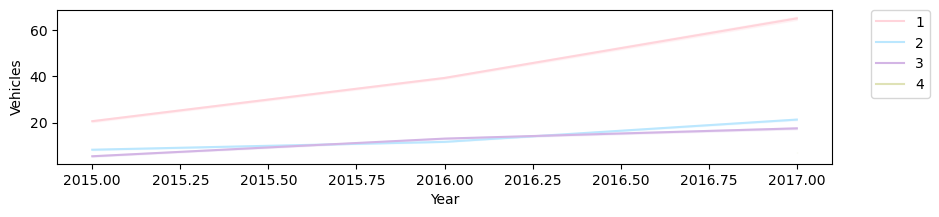

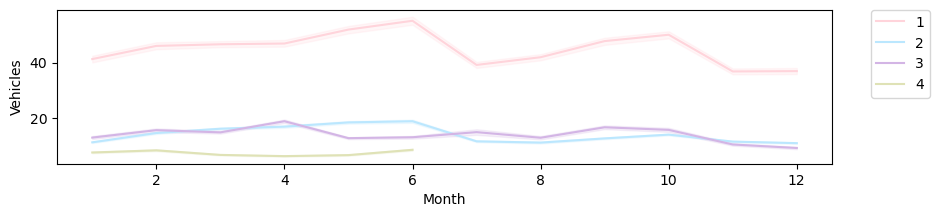

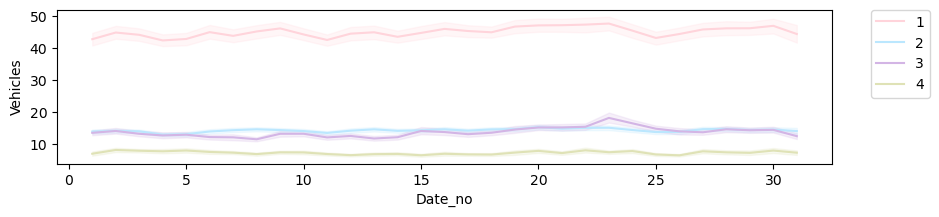

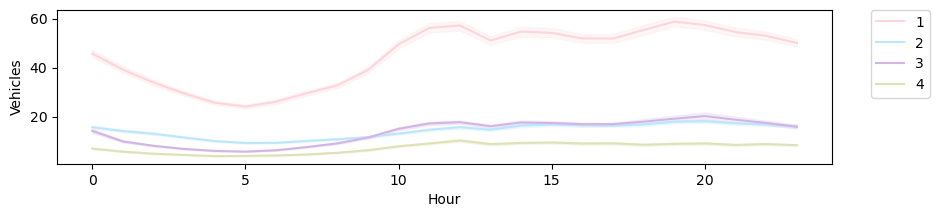

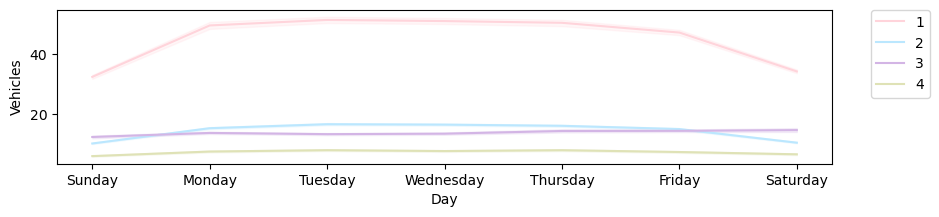

In [26]:
## plot TIme series data

created_feature = ['Year', 'Month', 'Date_no', 'Hour', 'Day']

for i in created_feature:
    plt.figure(figsize=(10, 2), dpi=100)
    ax = sns.lineplot(x=df_[i], y='Vehicles', data=df, hue='Junction', palette = palette)
    plt.legend(bbox_to_anchor = (1.05, 1), loc=2, borderaxespad=0.)

### From the above plot following things can be concluded:

- Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

- We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same.

- Monthly, throughout all the dates there is a good consistency in data.

- For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation.

- For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.

AttributeError: 'numpy.int64' object has no attribute 'startswith'

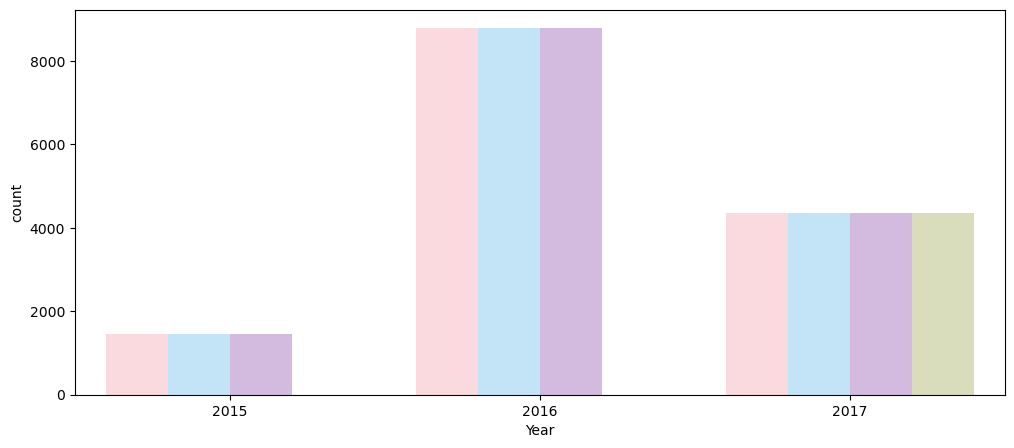

In [27]:
## plt

plt.figure(figsize=(12, 5), dpi=100)
count = sns.countplot(data=df_, x = df_['Year'], hue = 'Junction', palette = palette)
count.set_title('Count Of traffic On junction by years')
count.set_ylabel("Number of Vehicles")
count.set_xlabel('Year')

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month.

In [28]:
## Correleation metrx

corrmat = df_.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

ValueError: could not convert string to float: 'Sunday'

The highest correlation is certainly with the preexisting feature.

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data.

In [ ]:
## pair plot

sns.pairplot(data=df_, hue= "Junction",palette=palette)

## Conclusions that I have come to draw after this EDA

- The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
- The yearly trend for Junctions one, two and three have diffrent slopes.
- Junction number one has a more strong weekly seasonality in comparison to the other junctions.


For the above-postulated reasons, I think that junctions must be transformed as per their individual needs.

<h1><center>Data Pre-Processing</h1></center>

## In this step I will be following the subsequent order:

- Creating different frames for each Junction and plotting them
- Transforming the series and plotting them
- Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
- Creating test and train sets

In [29]:
## create pivot table 

df_junction  = df.pivot(columns='Junction', index="DateTime")
df_junction.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

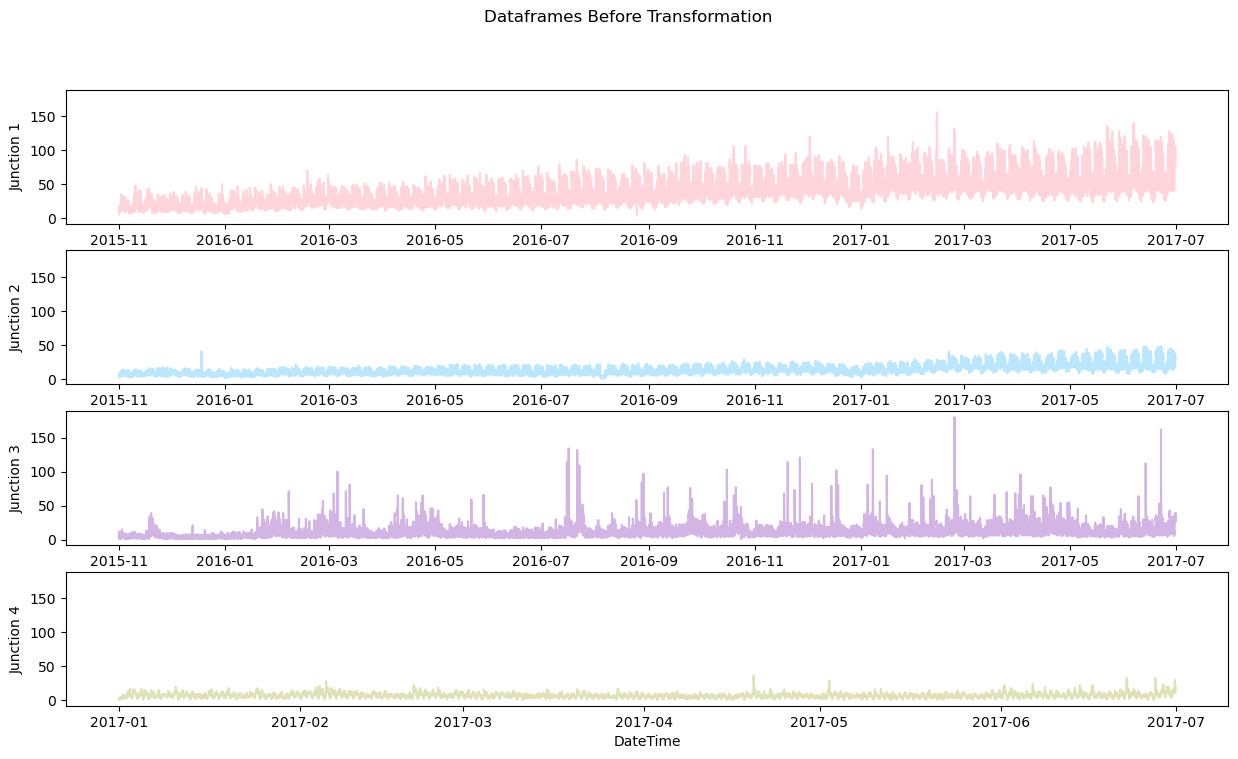

In [30]:
#Creating new sets

df_1 = df_junction[[('Vehicles', 1)]]
df_2 = df_junction[[('Vehicles', 2)]]
df_3 = df_junction[[('Vehicles', 3)]]
df_4 = df_junction[[('Vehicles', 4)]]
df_4 = df_4.dropna()

list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)
    
    #Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=palette[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=palette[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=palette[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=palette[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

Steps for Transforming:

- Normalizing
- Differencing

In [31]:
# Normalization Function

def Normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average)/stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

In [32]:
## Differencing Function

def Difference(df, col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] = df[col][i - interval]
        diff.append(value)
        
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:

- For Junction one, I will be taking a difference of weekly values.
- For junction two, The difference of consecutive days is a better choice
- For Junctions three and four, the difference of the hourly values will serve the purpose.

In [33]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

Plots of Transformed Dataframe

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")